In [1]:
import pandas as pd
import spacy
from spacy import displacy
import re
import numpy as np
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

NER = spacy.load("en_core_web_sm")

# Step 1. Data preparation

In [2]:
def prepare_df(df, cols_to_keep=['title', 'company', 'description', 'position']):
    new_df=df[cols_to_keep]
    return new_df

In [3]:
df=prepare_df(pd.read_csv('merged_4k.csv'))

In [4]:
def del_cont (text): 
    contractions = {"'s":" is", "n't":" not", "'m":" am", "'ve":" have", "'re":" are", "'ll": " will", "’ll":" will"}
    final=text
    for contr, full in contractions.items(): #the method for replacing contractions is retrieved from: https://stackoverflow.com/questions/14156473/can-you-write-a-str-replace-using-dictionary-values-in-python
        final=final.replace(contr, full)
    return final

In [5]:
no_contr=[]
for t in df['description']:
    no=del_cont(t)
    final = re.sub(r"[\n\r]"," ",no)
    no_contr.append(final)

In [6]:
df['description']=no_contr

In [7]:
df.head(5)

,title,company,description,position
0,University Grad Software Engineer (Canada),Pinterest,About Pinterest: Millions of people across the...,developer
1,Administration (1) - RPG AS400 Developer,Zwilling J.A. Henckels Canada Ltd,About ZWILLING J.A. Henckels: For over 285 yea...,developer
2,Senior Web Developer - Full Stack/Backend,WorkTango,WorkTango was founded as a passion-driven busi...,developer
3,React + Ruby on Rails Developer - Remote - Canada,FullStack Labs,FullStack Labs is the fastest-growing software...,developer
4,newSenior Back End Developer,BIMM,"BIMM is booming, so we’re looking for a Senior...",developer


# Step 2. NER MODEL

For extracting hard skills we use NER model from Spacy. 
This model recognizes named entities such as companies, people, dates and so on.

The model identifies some skills but also identifies a lot of things which are not skills. Thus, we shall apply the model along with a couple of restrictions:
- Stop words. We've identified some words which do not appear in the name of the skills but are identified as ORG by NER. So we do not include entitites containing these words.
- Uppercasing. Technical skills are the names of the programs (like Python, Java, etc) so we only keep entities which begin with the uppercase.
- We also exclude the company name from the description, because this is not a skill.

**Such moves will reduce the amount of skills extracted and we may potentially miss a lot of skills. However, this is a tolerable limitation for the 1st step, because for now, we just need to have at least some skills.**

## Actual program

In [8]:
stops=['group', 'ontario', 'canada', 'rights', 'salary', 'company', 'operation', 'inc.', 'co-op', 'internship', 'startup', 'job', 'career', 'friday']

In [9]:
def hard_skills(descr, compName):
    name=compName.lower()
    info=NER(descr)
    raw_skills=[]
    for ent in info.ents:
        if ent.text[0].isupper():
            extracted=ent.text.lower()
            if (ent.label_=='ORG' or ent.label=='PERSON') and extracted not in name and name not in extracted and not any(stop in extracted for stop in stops):
                raw_skills.append(extracted)
    ready_skills=[]
    for skill in raw_skills:
        splitted=re.split('[&,|/]', skill)
        for true_skill in splitted:
            if true_skill not in ready_skills:
                ready_skills.append(true_skill)
    return ready_skills

In [10]:
def add_hard_skills(df):
    hs=[]
    for row in df.itertuples(index=False):
        hs.append(hard_skills(row.description, row.company))
    new_df=df
    new_df['hard_skills']=hs
    return new_df

In [11]:
df_hard=add_hard_skills(df)
df_hard.head(5)

,title,company,description,position,hard_skills
0,University Grad Software Engineer (Canada),Pinterest,About Pinterest: Millions of people across the...,developer,"[python strong, li]"
1,Administration (1) - RPG AS400 Developer,Zwilling J.A. Henckels Canada Ltd,About ZWILLING J.A. Henckels: For over 285 yea...,developer,"[miyabi, rpg, ibm iseries, dependability resea..."
2,Senior Web Developer - Full Stack/Backend,WorkTango,WorkTango was founded as a passion-driven busi...,developer,"[material ui backend, aws, gitlab business]"
3,React + Ruby on Rails Developer - Remote - Canada,FullStack Labs,FullStack Labs is the fastest-growing software...,developer,"[uber, godaddy, mgm, siemens, stanford univer..."
4,newSenior Back End Developer,BIMM,"BIMM is booming, so we’re looking for a Senior...",developer,"[devops, node, js, aws familiarity, commercecl..."


## Test cases

In [12]:
def flat_2d_arr(arr):
    flat=[]
    for small in arr:
        for element in small:
            flat.append(element)
    return flat

In [13]:
def colour_skills(sent, c_s):
    result=''
    words=sent.split(' ')
    r_c=[]
    for skill in c_s:
        r_c.append(skill.split(' '))
    r_c=flat_2d_arr(r_c)
    for word in words:
        if word.lower() in r_c:
            
            result=result+'\033[39;46m{}\033[m'.format(word)+' '
        else:
            result=result+word+' '
    return result

### Successful case:

In [14]:
sent="Our candidates need to know SQL and PHP"

In [15]:
test1=hard_skills(sent, 'RBC')

In [16]:
print(colour_skills(sent, test1))

Our candidates need to know SQL and PHP 


### Failing cases:

#### False negative
Not all named entitites are identified by the pre-trained model

In [17]:
sent='Experience working with Python, R, NoSQL is required'

In [18]:
test2=hard_skills(sent, 'RBC')

In [19]:
print(colour_skills(sent, test2))

Experience working with Python, R, NoSQL is required 


#### False positive

Some words which are not skills are identified as skills

In [20]:
sent='Our startup has experience working for Stanford University'

In [21]:
test3=hard_skills(sent, 'Startup')

In [22]:
print(colour_skills(sent, test3))

Our startup has experience working for Stanford University 


## Skill's preprocessing

In [23]:
skills_arr=np.array(df_hard['hard_skills'])
skills_arr

array([list(['python strong', 'li']),
       list(['miyabi', 'rpg', 'ibm iseries', 'dependability research and', 'analysis operating equipment ethics and integrity planning and organizing communication', 'edi', 'a', 'r ', ' a', 'p', 'ftp', 'pos', 'documenting', 'db2', 'tcp', 'ip', 'ibm as400', 'ipl', 'sap', 'tm1', 'human resources']),
       list(['material ui backend', 'aws', ' gitlab business']), ...,
       list(['software engineer', 'java', 'maven', ' eclipse', 'netbeans', 'intellij', 'jpa', 'hibernate', 'dse graph', 'redis', 'junit', 'javascript']),
       list(['javascript', 'react suspense', 'hooks', 'workerswork', 'restful apisfamiliarity', 'scss', 'computer science', 'highcharts and material uibs in computer science', 'fintech']),
       list(['siding', ' roofing', ' doors or windows bilingual', 'building materials management'])],
      dtype=object)

In [24]:
skills_arr=flat_2d_arr(skills_arr)

Now, let's turn our skills into a set to delete repetitions.

In [25]:
set_skills=set(skills_arr)
set_skills

{'',
 'international',
 'easa',
 'mvp',
 'drug safety team',
 'owasp zap',
 'cgm',
 'major incident and problem management',
 'unity3d',
 'events',
 'transportation management system',
 'ps',
 "tre'dish qualifications ",
 'cix',
 'post trade',
 'data mining',
 'ddu',
 ' dec',
 'microsoft office (word and excel',
 'analyze',
 'rice university',
 'houdini sdk nice',
 'crm',
 'safe food for canadians regulations (sfcr',
 'tcp',
 ' beverage',
 'firepower',
 'pluralsight',
 'python js',
 'oracle cloud hcm payroll',
 'ge healthcare',
 'microsoft nav (navision',
 'capital markets’',
 'primary',
 'powerbuilder shell',
 'gemological institute of america',
 'tt',
 'duke university',
 'college degree in computer science',
 ' well-being communication ',
 'postal',
 'functions ',
 'financial accounting',
 'ms azure devops server',
 'indigenous',
 'operating systems knowledge',
 'database management',
 'parental ',
 'sym-tech facilitate',
 'integrated marketing campaign',
 'knowledge of web services

Now, let's delete empty entries and trailing whitespaces from the set

In [26]:
better_skills={x.strip() for x in set_skills if (x!='' and (len(x)>1 or x=='r'))}
better_skills={e for e in better_skills if (e!='')}
better_skills

{'international',
 'easa',
 'mvp',
 'drug safety team',
 'owasp zap',
 'cgm',
 'major incident and problem management',
 'unity3d',
 'events',
 'transportation management system',
 'ps',
 'compensation training',
 'cix',
 'post trade',
 'data mining',
 'ddu',
 'microsoft office (word and excel',
 'written communication',
 'analyze',
 'rice university',
 'houdini sdk nice',
 'serverless architecture',
 'crm',
 'safe food for canadians regulations (sfcr',
 'firepower',
 'tcp',
 'pluralsight',
 'python js',
 'oracle cloud hcm payroll',
 'ge healthcare',
 'microsoft nav (navision',
 'capital markets’',
 'primary',
 'powerbuilder shell',
 'gemological institute of america',
 'tt',
 'duke university',
 'college degree in computer science',
 'postal',
 'financial accounting',
 'ms azure devops server',
 'indigenous',
 'operating systems knowledge',
 'database management',
 'sym-tech facilitate',
 'integrated marketing campaign',
 'knowledge of web services',
 'well-being communication',
 'fin

Now, perform the same preprocessing for skills in our df

In [27]:
def basic_prepr_skills(df, col_skills):
    result=[]
    skills_2d=np.array(df[col_skills])
    for ent in skills_2d:
        prepr=[x.strip() for x in ent if (x!='' and (len(x)>1 or x=='r'))]
        prepr=[e for e in prepr if (e!='')]
        result.append(prepr)
    new_df=df
    new_df[col_skills]=result
    return new_df

In [28]:
df_hard_prepr=basic_prepr_skills(df_hard, 'hard_skills')

# Step 3. Retrieving more skills

## Useful methods:

In [29]:
def calc_occ(arr):
    cnt=Counter()
    for word in arr:
        cnt[word]+=1
    return cnt

In [30]:
def gen_wordCloud(arr):
    wordcloud = WordCloud(colormap='plasma', background_color='white', width=900, height=400).generate_from_frequencies(calc_occ(arr))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    return wordcloud

In [31]:
def merge_compound(nlp_tok):
    result=''
    for child in nlp_tok.children:
        if child.dep_ == "compound" and len([child for child in token.children])==0:
            return nlp_tok.text +' '+child.text
    return nlp_tok.head.text+ ' '+nlp_tok.text
    

In [32]:
def keep_percent(sort_arr, dec_keep):
    length=len(sort_arr)
    keep=length*dec_keep
    final=[]
    for word in sort_arr:
        final.append(word[0])
        if len(final)>=keep:
            break;
    return final
        

## Actual program

## We took the method from [this blog post](https://skeptric.com/extract-skills-2-adpositions/) and adapted it for the task at hand. To extract more skills we:
1. Identified the most popular heads of the skills

2. Retrieved the skills using the following process:
    
    - For each word check whether it is in the set of heads
    
    - If yes, check whether the word has a preposition
    
    - If yes, retrieve the object of this preposition and its leftmost meaningful child (this helps retrieves skills which are made of more than 1 word)
    


<hr/>
<strong>This method is not perfect, it does not retrieve some skills and retrieves a lot of words which are not skills. We created the list of stop words to help solve the second problem, however we could not get rid of non-skills words completely. However, we think the results are good enough, because a lot of useful skills were retrieved. Even if some words do not look exactly like skills they still can help one get a sense of what an employer in a given field is looking for </strong>

### Step 1. Retrieve all heads of skills and then keep only the most popular ones

In [33]:
heads=[]
all_descs=list(df_hard_prepr['description'])
for desc in all_descs:
    nlp_desc=NER(desc.lower()) 
    for token in nlp_desc:
        if any(token.text in skill for skill in better_skills) and token.is_stop==False and token.pos_ not in['PUNCT', 'SPACE', 'AUX']:
                    nlp_add=token
                    while (nlp_add.head.is_stop==True or nlp_add.head.pos_ in ['PUNCT', 'SPACE', 'AUX']) and nlp_add.text!=nlp_add.head.text:
                        nlp_add=nlp_add.head
                    if (nlp_add.head.is_stop==True or nlp_add.head.pos_ in ['PUNCT', 'SPACE', 'AUX']):
                        continue;
                    heads.append(nlp_add.head.text)

In [34]:
bh=[re.sub(r"[^a-z0-9 ]"," ", x) for x in heads ]
bh=[re.sub(r"\s{2,}", " ", x) for x in bh if x!=' ']
head_occ=calc_occ(bh).most_common()
head_best=keep_percent(head_occ, 0.01) #I keep only 1 percent of the most popular heads, it helps refine the next steps of the process

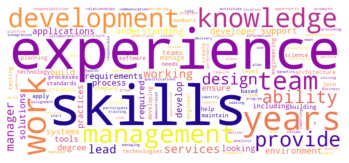

In [35]:
gen_wordCloud(head_best)

### Step 2. Retrieve more skills

In [37]:
one_stops=['experience', 'home', 'pressure', 'detail', 'behalf', 'work', 'ability', 
           'exceptional abilities', 'issues', 'view', 'development team', 'colleagues', 'example', 'regards', 'depth',
          'experience experience', 'line', '80,000', 'request', 'estimates', 'use', 'patients', 'solutions', 'benevity', 
          'customer sucess', 'clarity', 'code', 'key', 'network', 'global team', 'project team', 'support', 
           'incentive plans', 'team process', 'elements', 'disabilities', 'customers', 'life', 'senior management', 
           'new equipment', 'building', 'diversity', 'order', 'employers', 'operations', 'people', 'banking sector', 'vendors',
          'terms', 'high level', 'leaders', 'fit', 'products', 'progress', 'students', 'experience knowledge']
any_stops=['member','members', 'environment', 'candidate', 'candidates', 'ontario', 'canada', 'america', 
           'north', 'relevant', 'individual', 'individuals', 'teams', 'accordance', 'button', 'year', 
           'years', 'manager', 'equity', 'recruitment', 'results', 'staff', 'developer', 'california', 'experts',
          'applicants', 'inclusive', 'inclusion', 'clients', 'those', 'jobs', 'peers', 'toronto', '$', 'expert', 'sun', 
           'massachusetts', 'pennsylvania', 'illinois', 'ann', 'employee', 'employees', 'hours', 'partner', 'partners', 
           'day', 'passionate', 'success', 'daily', 'exist', 'existing', 'mate', 'mates', 'reliable', 'current', 
           'great', 'hands', 'immediate', 'citizenship', 'haves', 'www.cgi.com', 'stakeholders', 'completion',
          'employment', 'conjunction', 'pension', 'common']

In [38]:
def extr_prep_skills(descr):
    nlp_one=NER(descr.lower())
    skills_descr=[]
    for tok in nlp_one:
         if tok.text in head_best:
            for child in tok.rights:
                if child.dep_ == 'prep':
                    for obj in child.children:
                        if obj.dep_ == 'pobj':
                            if len([l for l in obj.lefts])>0:
                                for toadd in obj.lefts:
                                    if toadd.is_stop==False and toadd.pos_ not in ['PUNCT', 'SPACE', 'AUX']:
                                        fs=toadd.text + ' ' + obj.text
                                        if len(list(set(fs.split(' '))&set(any_stops)))==0 and fs not in one_stops and fs not in better_skills:
                                            skills_descr.append(fs)
                                            break;
                            elif obj.is_stop==False and obj.pos_ not in['PUNCT', 'SPACE', 'AUX']:
                                tc=obj.text
                                if  obj.dep_=='compound':
                                    tc=merge_compound(obj)
                                if tc not in better_skills and tc not in one_stops and tc not in any_stops and (len(tc)>1 or tc=='c'):
                                        skills_descr.append(tc)
    return skills_descr

In [39]:
other_skills=[]
for one_descr in df_hard_prepr['description']:
    other_skills.append(extr_prep_skills(one_descr))

In [40]:
df_hard_prepr['new_skills']=other_skills
df_final=basic_prepr_skills(df_hard_prepr, 'new_skills')
df_final.head(5)

,title,company,description,position,hard_skills,new_skills
0,University Grad Software Engineer (Canada),Pinterest,About Pinterest: Millions of people across the...,developer,"[python strong, li]","[university grads, previous proficiency]"
1,Administration (1) - RPG AS400 Developer,Zwilling J.A. Henckels Canada Ltd,About ZWILLING J.A. Henckels: For over 285 yea...,developer,"[miyabi, rpg, ibm iseries, dependability resea...","[esteemed brand, iseries platform, external sy..."
2,Senior Web Developer - Full Stack/Backend,WorkTango,WorkTango was founded as a passion-driven busi...,developer,"[material ui backend, aws, gitlab business]","[senior backend, addition, start up]"
3,React + Ruby on Rails Developer - Remote - Canada,FullStack Labs,FullStack Labs is the fastest-growing software...,developer,"[uber, godaddy, mgm, siemens, stanford univers...","[fullstack team, professional experience, larg..."
4,newSenior Back End Developer,BIMM,"BIMM is booming, so we’re looking for a Senior...",developer,"[devops, node, js, aws familiarity, commercecl...","[backend services, database schemas, web stack..."


## Test cases

### Successful case

In [58]:
sent='Our candidates need experience with backend services'

In [59]:
ns=NER(sent)
displacy.render(ns, style="dep")

In [60]:
test=extr_prep_skills(sent)

In [44]:
print(colour_skills(sent, test))

Our candidates need experience with backend services 


In [75]:
sent='The candidate need to be able to work with database schemas'
ns=NER(sent)
displacy.render(ns, style="dep")

In [76]:
test=extr_prep_skills(sent)
print(colour_skills(sent, test))

The candidate need to be able to work with database schemas 


### Failing cases

#### False Negative:
Not all skills presented in the text follow the structure we are extracting, some have more subtle structure which we did not extract

In [47]:
sent='The ideal candidate is perfect at negotiating with complicated clients'
ns=NER(sent)
displacy.render(ns, style="dep")

In [48]:
test=extr_prep_skills(sent)
print(colour_skills(sent, test))

The ideal candidate is perfect at negotiating with complicated clients 


#### False Postiive

In [88]:
sent='All our employees will work with professional psychologists'
ns=NER(sent)
displacy.render(ns, style="dep")

In [89]:
test=extr_prep_skills(sent)
print(colour_skills(sent, test))

All our employees will work with professional psychologists 


## Actual extraction

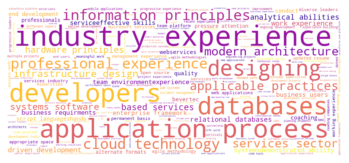

In [51]:
new_skills_arr=np.array(df_final['new_skills'])
new_skills_arr=flat_2d_arr(new_skills_arr)
gen_wordCloud(new_skills_arr)

In [48]:
df_final.to_csv('all_skills_4k.csv')

## Results:
- As can be seen the resulting skills we extracted are not all soft skills, some of them are just skills without a fixed name, or skills containing more than 1 word (not being compound at the same time). However, the results we achieved are still pretty good because we managed to extract a lot of skills